### Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import *

import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import warnings 
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 7)

### Loading the Dataset

In [2]:
df = pd.read_csv('BankChurners.csv.zip')
df = df.iloc[:, 1:21]

### Data Summary

<table style="width:100%">
  <tr>
    <th>Features</th>
    <th>Description</th>
    <th>Data Type</th>
  </tr>
  <tr>
    <td>Attrition_Flag</td>
    <td>Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"</td>
    <td>string (Nominal)</td>
  </tr>
   <tr>
    <td>Customer_Age</td>
    <td>Age in Years</td>
    <td>int</td>
  </tr> 
  <tr>
    <td>Gender</td>
    <td>Gender of the account holder</td>
    <td>string (Nominal)</td>
  </tr>
  <tr>
    <td>Dependent_count</td>
    <td>Number of dependents</td>
    <td>int</td>
  </tr>
  <tr>
    <td>Education_Level</td>
    <td>Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to a college student), Post-Graduate, Doctorate.</td>
    <td>string (Ordinal)</td>
  </tr>  
  <tr>
    <td>Marital_Status</td>
    <td>Marital status of the account holder</td>
    <td>string (Nominal)</td>
  </tr>
  <tr>
    <td>Income_Category</td>
    <td>Annual Income Category of the account holder</td>
    <td>string (Nominal)</td>
  </tr>
  <tr>
    <td>Card_Category</td>
    <td>Type of Card</td>
    <td>string (Ordinal)</td>
  </tr>  
  <tr>
    <td>Months_on_book</td>
    <td>Period of relationship with the bank</td>
    <td>int</td>
  </tr>
  <tr>
    <td>Total_Relationship_Count</td>
    <td>Total no. of products held by the customer</td>
    <td>int</td>
  </tr>   
   <tr>
    <td>Months_Inactive_12_mon</td>
    <td>No. of months inactive in the last 12 months</td>
    <td>int</td>
  </tr>   
   <tr>
    <td>Contacts_Count_12_mon</td>
    <td>No. of Contacts between the customer and bank in the last 12 months</td>
    <td>int</td>
  </tr>   
    <tr>
    <td>Credit_Limit</td>
    <td>Credit Limit on the Credit Card</td>
    <td>float</td>
  </tr>
   <tr>
    <td>Total_Revolving_Bal</td>
    <td>The balance that carries over from one month to the next is the revolving balance</td>
    <td>int</td>
  </tr>  
   <tr>
    <td>Avg_Open_To_Buy</td>
    <td>Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)</td>
    <td>float</td>
  </tr>  
    <tr>
    <td>Total_Trans_Amt</td>
    <td>Total Transaction Amount (Last 12 months)</td>
    <td>int</td>
  </tr> 
    <tr>
    <td>Total_Trans_Ct</td>
    <td>Total Transaction Count (Last 12 months)</td>
    <td>int</td>
  </tr> 
    <tr>
    <td>Total_Ct_Chng_Q4_Q1</td>
    <td>Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter</td>
    <td>float</td>
  </tr> 
    <tr>
    <td>Total_Amt_Chng_Q4_Q1</td>
    <td>Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter</td>
    <td>float</td>
  </tr> 
    <tr>
    <td>Avg_Utilization_Ration</td>
    <td>Represents how much of the available credit the customer spent</td>
    <td>float</td>
  </tr>
</table> 

### Exploratory Data Analysis

In [ ]:
plot_features(df, 'Marital_Status', 1)

In [ ]:
plot_features(df, 'Education_Level', 2)

In [ ]:
plot_features(df, 'Income_Category', 3)

Figure 1, 2, and 3 shows the distribution of the features that has 'Unknown' data points. <br><br>
Total # of Unknowns: <br>
`Marital_Status` = 749 datapoints which is 7.4% <br>
`Education_Level` = 1,519 datapoints which is 15.0% <br>
`Income_Category` = 1,112 datapoints which is 11.0% <br>

Total Unknown value = 3380

In [ ]:
plot_features(df, 'Attrition_Flag', 4)

The Attrited Customer data is at 16.07% which indicates that our dataset is imbalanced since we will be using the `Attrition_Flag` as target variable when feeding it to the Machine Learning models.

In [ ]:
corr_df = df.copy()
corr_df.Attrition_Flag = np.where(corr_df.Attrition_Flag == 'Existing Customer', 0, 1)

corr_ = corr_df.corr()
mask = np.triu(np.ones_like(corr_))
sns.heatmap(corr_, annot=True, mask=mask)
plt.title('Figure 5. Correlation Table');

The correlation table in Figure 5 shows that `Total_Relationship_Count`, `Credit_Limit`, `Total_Revolving_Bal`, `Total_Amt_Chng_Q4_Q1`, `Total_Trans_Amt`, `Total_Trans_Ct`, `Total_Ct_Chng_Q4_Q1` and `Avg_Utilization_Ratio` are negatively correlated with `Attrition_Flag`. <br> This means the lower the values of these features, the higher the chances of a customer to churn.

In [ ]:
sns.pairplot(data=df, hue='Attrition_Flag', corner=True)
plt.title('Figure 6. Pair Plot of All Numerical Features');

The pair plot shows the different distribution plots of the numerical features of the dataset which is segregated by `Attrition_Flag`.

### Data Cleaning and Pre-Processing (Step 1 to 4)

#### Step 1. Identify missing values in tabular data
Missing values were identified in the bar plots under Exploratory Data Analysis where they were tagged as `Unknown` datapoints. 

#### Step 2. Eliminate samples or features with missing values
The missing values tagged as 'Unknown' are removed in the dataset before feeding it into the machine learning model. A total of 3,380 unknown values would be removed.

In [3]:
# Dropping Unknown in the Dataset
bank_df = df[df.Marital_Status != 'Unknown']
bank_df = bank_df[bank_df.Education_Level != 'Unknown']
bank_df = bank_df[bank_df.Income_Category != 'Unknown']

#### Step 3. Imputing missing values
No missing values were imputed since they were removed.

#### Step 4. Handling Categorical data
Ordinal features like `Education_Level` and `Card_Category` were converted to numerical values but still represented ranking. Nominal features like `Attrition_Flag` and `Gender` were converted to binary representative (1,0) and nominal features like `Marital_Status` and `Income_Category` were one-hot-encoded to represent their numerical values.

In [4]:
# Mapping Ordinal Variables
education = {
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Post-Graduate': 3,
    'Doctorate': 4
}

card = {
    'Blue': 0,
    'Silver': 1,
    'Gold': 2,
    'Platinum': 3
}

# Converting Categorical Variables to Numerical
bank_df.Attrition_Flag = np.where(bank_df.Attrition_Flag == 'Existing Customer', 0, 1)
bank_df.Gender = np.where(bank_df.Gender == 'Male', 1, 0)
bank_df.Education_Level = np.where(bank_df.Education_Level == 'Graduate', 'College', bank_df.Education_Level)
bank_df.Education_Level = bank_df.Education_Level.map(education)
bank_df.Card_Category = bank_df.Card_Category.map(card)

# One-Hot Encoding of Categorical Variables
bank_df = pd.get_dummies(bank_df, columns=['Marital_Status', 'Income_Category'], drop_first=True)

### Step 5. Bringing features onto the same scale
We check if we need to scale the data. Based on the max value per column, we need to scale the data to set them in the same scale. The scaling is done within the machine learning model function in `utilities.py`.

In [5]:
# To check if the dataset needs scaling
bank_df.describe()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K
count,7081.000000,7081.000000,7081.0,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,...,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.00000,7081.000000
mean,0.157181,46.347691,0.0,2.337805,1.588476,0.082757,35.981359,3.819376,2.342607,2.454456,...,4394.299816,64.503319,0.711508,0.282313,0.503319,0.416325,0.199407,0.155769,0.16975,0.394295
std,0.363997,8.041225,0.0,1.291649,1.003723,0.328819,8.002609,1.544444,0.995104,1.104917,...,3468.461606,23.809330,0.238693,0.278731,0.500024,0.492984,0.399583,0.362662,0.37544,0.488733
min,0.000000,26.000000,0.0,0.000000,0.000000,0.000000,13.000000,1.000000,0.000000,0.000000,...,510.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,41.000000,0.0,1.000000,1.000000,0.000000,31.000000,3.000000,2.000000,2.000000,...,2089.000000,44.000000,0.583000,0.026000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,46.000000,0.0,2.000000,2.000000,0.000000,36.000000,4.000000,2.000000,2.000000,...,3831.000000,67.000000,0.700000,0.186000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,52.000000,0.0,3.000000,2.000000,0.000000,40.000000,5.000000,3.000000,3.000000,...,4740.000000,80.000000,0.818000,0.515000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000
max,1.000000,73.000000,0.0,5.000000,4.000000,3.000000,56.000000,6.000000,6.000000,6.000000,...,17995.000000,134.000000,3.714000,0.999000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


### Setting up Features and Target Variable

In [6]:
X = bank_df.iloc[:, 1:] # features
y = bank_df.Attrition_Flag # target variable

### Machine Learning Models

In [7]:
# Computing PCC for benchmark on Classifier Models
pcc = 1.25*((y.value_counts()/len(y))**2).sum() * 100
pcc

91.88118427713643

In [8]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, 
                                           stratify=y)

In [9]:
# initialize models with default hyperparamters
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    #'LinearSVM': SVC(kernel='linear'),
    #'RBFSVM': SVC(),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}

In [10]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    recall_test = []
    precision_test = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_score = model.score(X_train, y_train)
        val_score = model.score(X_val, y_val)
        recall = recall_score(y_val, model.predict(X_val))
        precision = precision_score(y_val, model.predict(X_val))
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        recall_test.append(recall)
        precision_test.append(precision)
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'ave_recall_score':np.mean(recall_test) * 100,
        'ave_precision_score':np.mean(precision_test) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
summary_df = pd.DataFrame(res).T
display(summary_df)

100%|██████████| 6/6 [00:18<00:00,  3.11s/it]

Report Generated in 18.69 seconds


,ave_train_acc,ave_val_acc,ave_recall_score,ave_precision_score,run_time
KNeighborsClassifier,92.165725,89.435028,55.329341,71.232318,1.123502
LogisticRegressor,87.862524,88.003766,41.916168,69.731612,0.109707
GaussianNB,89.303202,89.284369,61.437126,67.544962,0.027926
RandomForestClassifier,100.000000,95.103578,75.329341,92.155767,0.951964
DecisionTreeClassifier,100.000000,93.069680,76.287425,78.956821,0.056845
GradientBoostingClassifier,97.961394,96.026365,82.155689,91.789598,1.495502


4it [00:00, 81.85it/s]


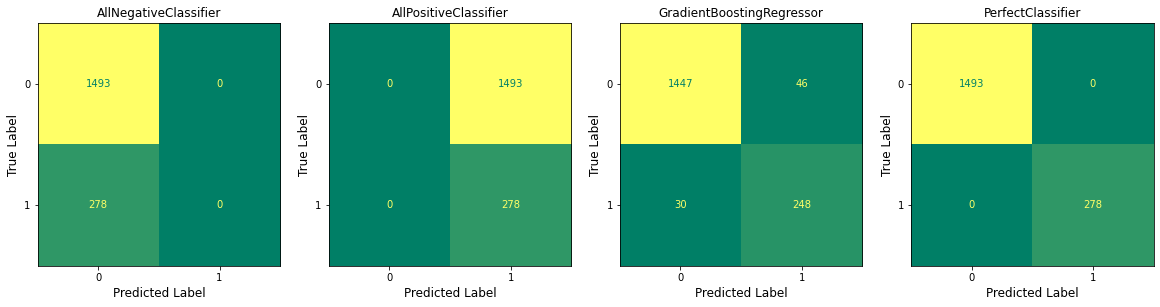

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model = GradientBoostingClassifier()
best_model.fit(X_trainval, y_trainval)
y_pred = model.predict(X_holdout)

eval_dict = {
    'AllNegativeClassifier': np.zeros(y_holdout.shape),
    'AllPositiveClassifier' : np.ones(y_holdout.shape),
    'GradientBoostingRegressor': y_pred,
    'PerfectClassifier': y_holdout
}

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for index, (model_name, preds) in tqdm(enumerate(eval_dict.items())):
    ConfusionMatrixDisplay.from_predictions(y_holdout, preds, 
                                            ax=axes[index], cmap='summer',
                                            colorbar=False)
    axes[index].set_title(model_name, fontsize=12)
    axes[index].set_xlabel('Predicted Label', fontsize=12)
    axes[index].set_ylabel('True Label', fontsize=12)

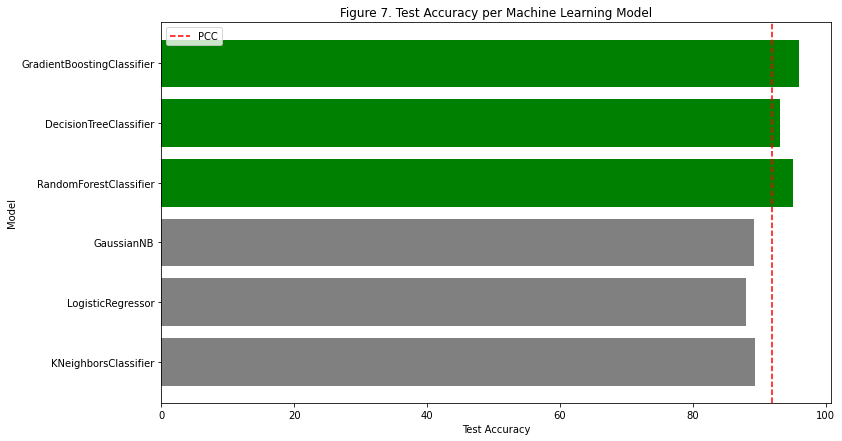

In [11]:
fig, ax = plt.subplots()
plt.barh(summary_df.index, summary_df['ave_val_acc'], color=['gray', 'gray', 'gray', 'g', 'g', 'g'])
ax.axvline(pcc, color='red', linestyle='--', label='PCC')
plt.ylabel('Model')
plt.xlabel('Test Accuracy')
plt.legend()
plt.title('Figure 7. Test Accuracy per Machine Learning Model');

### Feature Importance

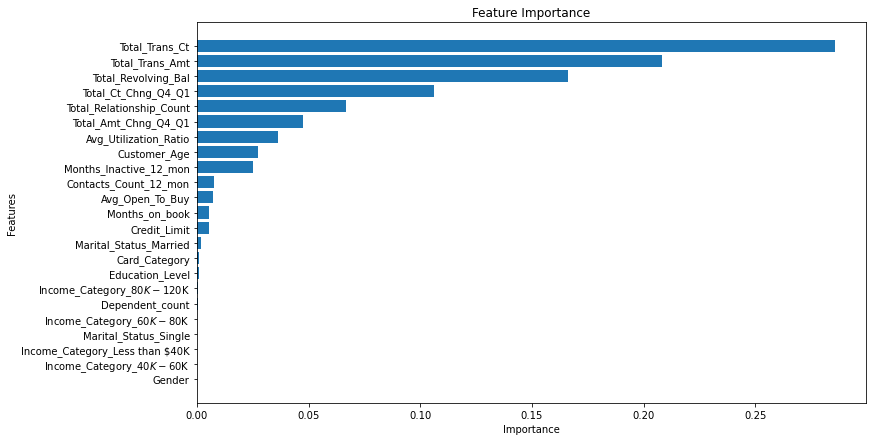

In [12]:
svc = GradientBoostingClassifier(n_estimators=300,max_depth=3, max_features=0.8).fit(X_train, y_train)

coefs = svc.feature_importances_
abs_coefs = np.abs(coefs[:])
coefs_count = len(abs_coefs)

fig, ax = plt.subplots()
ax.barh(np.arange(coefs_count), sorted(abs_coefs))
ax.set_yticks(np.arange(coefs_count))
ax.set_yticklabels(X.columns[np.argsort(abs_coefs)])
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance');

### Using SMOTE

In [14]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    recall_test = []
    precision_test = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        smote = SMOTE(sampling_strategy=0.4, random_state=123)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train_smote, y_train_smote)
        
        # default metric: accuracy
        train_score = model.score(X_train_smote, y_train_smote)
        val_score = model.score(X_val, y_val)
        recall = recall_score(y_val, model.predict(X_val))
        precision = precision_score(y_val, model.predict(X_val))
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        recall_test.append(recall)
        precision_test.append(precision)
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'ave_recall_score':np.mean(recall_test) * 100,
        'ave_precision_score':np.mean(precision_test) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
summary_df = pd.DataFrame(res).T
display(summary_df)

100%|██████████| 6/6 [00:30<00:00,  5.10s/it]

Report Generated in 30.63 seconds


,ave_train_acc,ave_val_acc,ave_recall_score,ave_precision_score,run_time
KNeighborsClassifier,92.438148,87.947269,69.940120,60.094184,1.966866
LogisticRegressor,83.659218,87.438795,62.035928,60.030544,0.328387
GaussianNB,84.177973,84.011299,72.814371,49.475418,0.033896
RandomForestClassifier,100.000000,95.442561,80.838323,89.173780,1.404101
DecisionTreeClassifier,100.000000,92.768362,77.365269,76.881839,0.102725
GradientBoostingClassifier,97.581804,96.214689,86.467066,89.138174,2.040572


### Using ADASYN

In [27]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    recall_test = []
    precision_test = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        adasyn = ADASYN(sampling_strategy=0.4, random_state=123)
        X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train_adasyn, y_train_adasyn)
        
        # default metric: accuracy
        train_score = model.score(X_train_adasyn, y_train_adasyn)
        val_score = model.score(X_val, y_val)
        recall = recall_score(y_val, model.predict(X_val))
        precision = precision_score(y_val, model.predict(X_val))
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        recall_test.append(recall)
        precision_test.append(precision)
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'ave_recall_score':np.mean(recall_test) * 100,
        'ave_precision_score':np.mean(precision_test) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
summary_df = pd.DataFrame(res).T
display(summary_df)

100%|██████████| 6/6 [00:30<00:00,  5.11s/it]

Report Generated in 30.66 seconds


,ave_train_acc,ave_val_acc,ave_recall_score,ave_precision_score,run_time
KNeighborsClassifier,91.807495,86.930320,70.778443,56.892510,1.666217
LogisticRegressor,81.157752,85.743879,53.772455,55.001232,0.142618
GaussianNB,84.439736,84.576271,72.934132,50.665911,0.032912
RandomForestClassifier,100.000000,95.612053,81.556886,89.680209,1.224282
DecisionTreeClassifier,100.000000,92.278719,80.000000,73.374331,0.098736
GradientBoostingClassifier,97.527991,96.195857,86.826347,88.755884,1.785104


### Using SMOTENC

In [30]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    recall_test = []
    precision_test = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        smotenc = SMOTENC(categorical_features=[bank_df["Attrition_Flag"].min(),
                                                bank_df["Attrition_Flag"].max()],
                          sampling_strategy=0.4, random_state=123)
        X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train_smotenc, y_train_smotenc)
        
        # default metric: accuracy
        train_score = model.score(X_train_smotenc, y_train_smotenc)
        val_score = model.score(X_val, y_val)
        recall = recall_score(y_val, model.predict(X_val))
        precision = precision_score(y_val, model.predict(X_val))
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        recall_test.append(recall)
        precision_test.append(precision)
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'ave_recall_score':np.mean(recall_test) * 100,
        'ave_precision_score':np.mean(precision_test) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
summary_df = pd.DataFrame(res).T
display(summary_df)

100%|██████████| 6/6 [00:35<00:00,  6.00s/it]

Report Generated in 36.00 seconds


,ave_train_acc,ave_val_acc,ave_recall_score,ave_precision_score,run_time
KNeighborsClassifier,92.438148,87.947269,69.940120,60.094184,1.548382
LogisticRegressor,83.467678,87.664783,63.113772,60.542437,0.217925
GaussianNB,83.850758,83.898305,73.053892,49.260001,0.031425
RandomForestClassifier,100.000000,95.612053,81.916168,89.379756,1.475358
DecisionTreeClassifier,100.000000,92.749529,77.964072,76.509383,0.084772
GradientBoostingClassifier,97.621708,96.120527,85.988024,88.988033,2.115361
